## Variational-based Matrix Product State Compression


Author: Micheal C. Chen

Email: muchuchen03@gmail.com

Matrix product state (MPS) is a compact, structured representation of many-body wave functions. An N-site state $|\psi\rangle$ with local physical dimension $d$ is written as a chain of rank-3 tensors:
$$
|\psi\rangle=\sum_{\{s_i\}} A^{[1]s_1}A^{[2]s_2}\cdots A^{[N]s_N}\,|s_1s_2\ldots s_N\rangle .
$$
Each $A^{[i]s_i}$ carries one physical index $s_i\in\{1,\dots,d\}$ and two bond indices of dimensions $D_{i-1},D_i$. The maximal bond dimension $D=\max_i D_i$ controls the expressive power: larger $D$ can capture more entanglement but increases memory and contraction cost (typically $O(N\,d\,D^3)$ for standard operations).

In practice we often need to **compress** a “large” MPS $|\psi_A\rangle$ (bond $D_s$) into a “smaller” one $|\psi_B\rangle$ (bond $\chi\ll D_s$) while preserving fidelity. This demo implements a **variational compression** procedure: we choose $|\psi_B\rangle$ to minimize the least-squares error
$$
\varepsilon=\bigl\|\,|\psi_A\rangle-|\psi_B\rangle\,\bigr\|^2
=\langle\psi_A|\psi_A\rangle+\langle\psi_B|\psi_B\rangle
-2\,\mathrm{Re}\,\langle\psi_B|\psi_A\rangle .
$$

In [14]:
import numpy as np
import numpy.linalg as LA
from scipy import linalg

For tensor operations, we define useful functions `NCon` for tensor contraction and `Group` for tensor reshape. The code is provided by Prof. Shuo Yang.

In [15]:
def Group(A,shapeA):
	""" transpose + reshape """
	dimA = np.asarray(np.shape(A))
	rankA = len(shapeA)
	shapeB = []
	for i in range(0,rankA):
		shapeB += [np.prod(dimA[shapeA[i]])]
	orderB = sum(shapeA,[])
	A = np.reshape(np.transpose(A,orderB),shapeB)
	return A

def NCon(Tensor,Index):
	ConList = range(1,max(sum(Index,[]))+1)
	while len(ConList) > 0:
		Icon = []
		for i in range(len(Index)):
			if ConList[0] in Index[i]:
				Icon.append(i)
				if len(Icon) == 2:
					break
		if len(Icon) == 1:
			IndCommon = list(set([x for x in Index[Icon[0]] if Index[Icon[0]].count(x)>1]))
			
			for icom in range(len(IndCommon)):
				Pos = sorted([i for i,x in enumerate(Index[Icon[0]]) if x==IndCommon[icom]])
				Tensor[Icon[0]] = np.trace(Tensor[Icon[0]],axis1=Pos[0],axis2=Pos[1])
				Index[Icon[0]].pop(Pos[1])
				Index[Icon[0]].pop(Pos[0])
		else:
			IndCommon = list(set(Index[Icon[0]]) & set(Index[Icon[1]]))		
			Pos = [[],[]]
			for i in range(2):
				for ind in range(len(IndCommon)):
					Pos[i].append(Index[Icon[i]].index(IndCommon[ind]))
			A = np.tensordot(Tensor[Icon[0]],Tensor[Icon[1]],(Pos[0],Pos[1]))
			
			for i in range(2):
				for ind in range(len(IndCommon)):
					Index[Icon[i]].remove(IndCommon[ind])
			Index[Icon[0]] = Index[Icon[0]]+Index[Icon[1]]
			Index.pop(Icon[1])
			Tensor[Icon[0]] = A
			Tensor.pop(Icon[1])
		ConList = list(set(ConList)^set(IndCommon))
	while len(Index) > 1:
		
		Tensor[0] = np.multiply.outer(Tensor[0],Tensor[1])
		Tensor.pop(1)
		Index[0] = Index[0]+Index[1]
		Index.pop(1)
	Index = Index[0]
	if len(Index) > 0:
		Order = sorted(range(len(Index)),key=lambda k:Index[k])[::-1]	
		Tensor = np.transpose(Tensor[0],Order)
	else:
		Tensor = Tensor[0]
	return Tensor

In [16]:
def Mps_LQP(T,UR,icheck=0):
	""" (0-T-L)(0-UR-1) -> (0-UL-1)(0-Tnew-L) """
	shapeT = np.asarray(np.shape(T))
	rankT = len(shapeT)
	
	A = np.tensordot(T,UR,(rankT-1,0))
	A = np.reshape(A,[shapeT[0],np.prod(shapeT[1:])])
	UL,Tnew = linalg.rq(A,mode = 'economic')
	Sign = np.diag(np.sign(np.diag(UL)))
	UL = np.dot(UL,Sign)
	Tnew = np.dot(Sign,Tnew)
	Tnew = np.reshape(Tnew,shapeT)
	
	if icheck == 1:
		A = np.reshape(A,shapeT)
		B = np.tensordot(UL,Tnew,(1,0))
		print(LA.norm(A-B)/LA.norm(A))
		A = np.tensordot(np.conj(Tnew),Tnew,(range(1,rankT),range(1,rankT)))
		print(LA.norm(A-np.eye(shapeT[0])))
	
	return UL,Tnew

def Mps_QRP(UL,T,icheck=0):
	""" (0-UL-1)(0-T-L) -> (0-Tnew-L)(0-UR-1) """
	shapeT = np.asarray(np.shape(T))
	rankT = len(shapeT)
	
	A = np.tensordot(UL,T,(1,0))
	A = np.reshape(A,[np.prod(shapeT[:-1]),shapeT[-1]])
	Tnew,UR = linalg.qr(A,mode = 'economic')
	Sign = np.diag(np.sign(np.diag(UR)))
	Tnew = np.dot(Tnew,Sign)
	UR = np.dot(Sign,UR)
	Tnew = np.reshape(Tnew,shapeT)
	
	if icheck == 1:
		A = np.reshape(A,shapeT)
		B = np.tensordot(Tnew,UR,(rankT-1,0))
		print(LA.norm(A-B)/LA.norm(A))
		A = np.tensordot(np.conj(Tnew),Tnew,(range(0,rankT-1),range(0,rankT-1)))
		print(LA.norm(A-np.eye(shapeT[-1])))
	
	return Tnew,UR

def Mps_LQP(T,UR,icheck=0):
	""" (0-T-L)(0-UR-1) -> (0-UL-1)(0-Tnew-L) """
	shapeT = np.asarray(np.shape(T))
	rankT = len(shapeT)
	
	A = np.tensordot(T,UR,(rankT-1,0))
	A = np.reshape(A,[shapeT[0],np.prod(shapeT[1:])])
	UL,Tnew = linalg.rq(A,mode = 'economic')
	Sign = np.diag(np.sign(np.diag(UL)))
	UL = np.dot(UL,Sign)
	Tnew = np.dot(Sign,Tnew)
	Tnew = np.reshape(Tnew,shapeT)
	
	if icheck == 1:
		A = np.reshape(A,shapeT)
		B = np.tensordot(UL,Tnew,(1,0))
		print(LA.norm(A-B)/LA.norm(A))
		A = np.tensordot(np.conj(Tnew),Tnew,(range(1,rankT),range(1,rankT)))
		print(LA.norm(A-np.eye(shapeT[0])))
	
	return UL,Tnew

def Mps_QR0P(T,icheck=0):
	""" (0-T-L) -> (0-Tnew-L)(0-UR-1) """
	shapeT = np.asarray(np.shape(T))
	rankT = len(shapeT)
	
	A = np.reshape(T,[np.prod(shapeT[:-1]),shapeT[-1]])
	Tnew,UR = linalg.qr(A,mode = 'economic')
	Sign = np.diag(np.sign(np.diag(UR)))
	Tnew = np.dot(Tnew,Sign)
	UR = np.dot(Sign,UR)
	Tnew = np.reshape(Tnew,shapeT)
	
	if icheck == 1:
		B = np.tensordot(Tnew,UR,(rankT-1,0))
		print(LA.norm(T-B)/LA.norm(T))
		A = np.tensordot(np.conj(Tnew),Tnew,(range(0,rankT-1),range(0,rankT-1)))
		print(LA.norm(A-np.eye(shapeT[-1])))
	
	return Tnew,UR

def Mps_LQ0P(T,icheck=0):
	""" (0-T-L) -> (0-UL-1)(0-Tnew-L) """
	shapeT = np.asarray(np.shape(T))
	rankT = len(shapeT)
	
	A = np.reshape(T,[shapeT[0],np.prod(shapeT[1:])])
	UL,Tnew = linalg.rq(A,mode = 'economic')
	Sign = np.diag(np.sign(np.diag(UL)))
	UL = np.dot(UL,Sign)
	Tnew = np.dot(Sign,Tnew)
	Tnew = np.reshape(Tnew,shapeT)
	
	if icheck == 1:
		B = np.tensordot(UL,Tnew,(1,0))
		print(LA.norm(T-B)/LA.norm(T))
		A = np.tensordot(np.conj(Tnew),Tnew,(range(1,rankT),range(1,rankT)))
		print(LA.norm(A-np.eye(shapeT[0])))
	
	return UL,Tnew

## Distance Calculation
In order to calculate the distance between two MPSs, we define function `CalOverlapMps` to calculate two MPS $|\psi_A\rangle$ and $|\psi_B\rangle$ overlap $\langle \psi_B | \psi_A|\rangle$. And the norm-2 of $|\psi_A\rangle$ and $|\psi_B\rangle$ is:
$$
\varepsilon=\bigl\|\,|\psi_A\rangle-|\psi_B\rangle\,\bigr\|^2
=\langle\psi_A|\psi_A\rangle+\langle\psi_B|\psi_B\rangle
-2\,\mathrm{Re}\,\langle\psi_B|\psi_A\rangle .
$$


In [27]:
def CalOverlapMps(Mps1, Mps2):
    Val = np.array([[1.0 + 0j]])
    Ns = len(Mps1)
    for site in range(Ns):
        Val = NCon([Val, Mps1[site], np.conj(Mps2[site])], [[1, 2], [1, 3, -1], [2, 3, -2]])
    return np.abs(Val[0][0])

def Norm2Mps(Mps1, Mps2):
    return np.abs(CalOverlapMps(Mps1,Mps1) + CalOverlapMps(Mps2,Mps2) - 2 * np.real(CalOverlapMps(Mps1,Mps2)))

## MPS and Ansatz Initialization
Firstly we prepare a random many-body state in Matrix Product State (MPS) form and immediately place it in a numerically stable **left-canonical** gauge before variational optimization.

For a chain of length $N_s$ and local dimension $d$, each site tensor is drawn as a complex array to avoid accidental degeneracies. The virtual (bond) dimensions are capped to balance expressivity and cost. Near the edges, the exact Schmidt ranks of a generic state grow like powers of $d$, so the left/right bond sizes are limited by those powers and by a global cap. 

Immediately after initialization, the state is brought into a **left-canonical** form by sweeping the orthogonality center from the right boundary to the left. Conceptually, one repeatedly factors each site tensor together with a unitary carried from the right boundary so that the updated site becomes an isometry on its left bond.


In [28]:
def InitMPS(Ns, Dp, Ds):
    Mps = [None] * Ns
    for site in range(Ns):
        left_bond_dim = min(Dp**site, Dp**(Ns-site), Ds)
        right_bond_dim = min(Dp**(site+1), Dp**(Ns-site-1), Ds)
        Mps[site] = np.random.rand(left_bond_dim, Dp, right_bond_dim) + 1j * np.random.rand(left_bond_dim, Dp, right_bond_dim)

    U = np.eye(np.shape(Mps[-1])[-1])
    for site in range(Ns - 1, -1, -1):
        U, Mps[site] = Mps_LQP(Mps[site], U)
    return Mps

def InitAnsatz(Ns, Dp, chi):
    Ansatz = [None] * Ns
    for site in range(Ns):
        left_bond_dim = min(Dp**site, Dp**(Ns-site), chi)
        right_bond_dim = min(Dp**(site+1), Dp**(Ns-site-1), chi)
        Ansatz[site] = np.random.rand(left_bond_dim, Dp, right_bond_dim) + 1j * np.random.rand(left_bond_dim, Dp, right_bond_dim)

    U = np.eye(np.shape(Ansatz[-1])[-1])
    for site in range(Ns - 1, -1, -1):
        U, Ansatz[site] = Mps_LQP(Ansatz[site], U)
    return Ansatz

We immediately initialize corresponding environments. In this case, there are two kinds of environments `NL`, `NR` and `WL`, `WR`. In future sweep, they will be utilized to construct $N_{eff}$ and $W_{eff}$

In [29]:
def InitEnv(Mps, Ansatz):
    Ns = len(Mps)
    NL = [None] * Ns
    NR = [None] * Ns
    NL[0] = np.array([[1.0+0j]])
    NR[-1] = np.array([[1.0+0j]])
    for site in range(Ns - 1, 0, -1):
        NR[site-1] =  NCon([NR[site], Ansatz[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])

    WL = [None] * Ns
    WR = [None] * Ns
    WL[0] = np.array([[1.0+0j]])
    WR[-1] = np.array([[1.0+0j]])
    for site in range(Ns - 1, 0, -1):
        WR[site-1] = NCon([WR[site], Mps[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])
        
    return NL, NR, WL, WR

Now we perform sweep back and forth until convergence.

In [43]:
Ns =100
Dp = 2
Ds = 100
chi = 2
Mps = InitMPS(Ns, Dp, Ds)
Ansatz = InitAnsatz(Ns, Dp, chi)
NL, NR, WL, WR = InitEnv(Mps, Ansatz)
err_per_sweep = []
for sweep in range(100):
    
    for site in range(Ns - 1):
        Dl, Dp, Dr = np.shape(Ansatz[site])
        Neff  = NCon([NL[site], np.eye(Dp), NR[site]], [[-1, -4], [-5, -2], [-6, -3]])
        Weff = NCon([WL[site], Mps[site], WR[site]], [[-1, 1], [1, -2 , 2], [2, -3]])
        Neff = Group(Neff, [[0, 1, 2], [3, 4, 5]])
        Weff = Group(Weff, [[0, 1, 2]])

        # T_vec = LA.solve(Neff, Weff)
        # T = np.reshape(T_vec, (Dl * Dp, Dr))
        # Q, r = LA.qr(T)
        # Ansatz[site] = np.reshape(Q, (Dl, Dp, Dr))
        T_vec = np.reshape(LA.solve(Neff, Weff), (Dl, Dp, Dr))
        Ansatz[site], U = Mps_QR0P(T_vec)

        NL[site+1] = NCon([NL[site], np.conj(Ansatz[site]), Ansatz[site]], [[1, 2], [1, 3, -1], [2, 3, -2]])
        WL[site+1] = NCon([WL[site], np.conj(Ansatz[site]), Mps[site]], [[1, 2], [1, 3, -1], [2, 3, -2]])
        # Ansatz[site+1] = np.tensordot(r, Ansatz[site+1], (1, 0))
        Ansatz[site+1] = np.tensordot(U, Ansatz[site+1], (1, 0))
        
    for site in range(Ns-1, 0, -1):
        Dl, Dp, Dr = np.shape(Ansatz[site])
        Neff  = NCon([NL[site], np.eye(Dp), NR[site]], [[-1, -4], [-5, -2], [-6, -3]])
        Weff = NCon([WL[site], Mps[site], WR[site]], [[-1, 1], [1, -2 , 2], [2, -3]])
        Neff = Group(Neff, [[0, 1, 2], [3, 4, 5]])
        Weff = Group(Weff, [[0, 1, 2]])

        # T_vec = LA.solve(Neff, Weff)
        # T = np.reshape(T_vec, (Dl, Dp* Dr))
        # Q, r = LA.qr(T)
        # L = np.conj(r).T
        # U = np.conj(Q).T
        # Ansatz[site] = np.reshape(L, (Dl, Dp, Dr))
        T_vec = np.reshape(LA.solve(Neff, Weff), (Dl, Dp, Dr))
        U, Ansatz[site] = Mps_LQ0P(T_vec)
        NR[site-1] = NCon([NR[site], Ansatz[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])
        WR[site-1] = NCon([WR[site], Mps[site], np.conj(Ansatz[site])], [[1, 2], [-1, 3, 1], [-2, 3, 2]])
        # Ansatz[site-1] = np.tensordot(Ansatz[site-1], U, (2, 0))
        Ansatz[site-1] = np.tensordot(Ansatz[site-1], U, (2, 0))
        
    err_per_sweep.append(Norm2Mps(Mps, Ansatz))
    print(f"Sweep {sweep:3d}  ||MPS-Ansatz||^2 = {err_per_sweep[-1]:.6e}")

Sweep   0  ||MPS-Ansatz||^2 = 1.658127e-06
Sweep   1  ||MPS-Ansatz||^2 = 1.621669e-06
Sweep   2  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   3  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   4  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   5  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   6  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   7  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   8  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep   9  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  10  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  11  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  12  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  13  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  14  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  15  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  16  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  17  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  18  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  19  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  20  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  21  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  22  ||MPS-Ansatz||^2 = 1.621659e-06
Sweep  23  

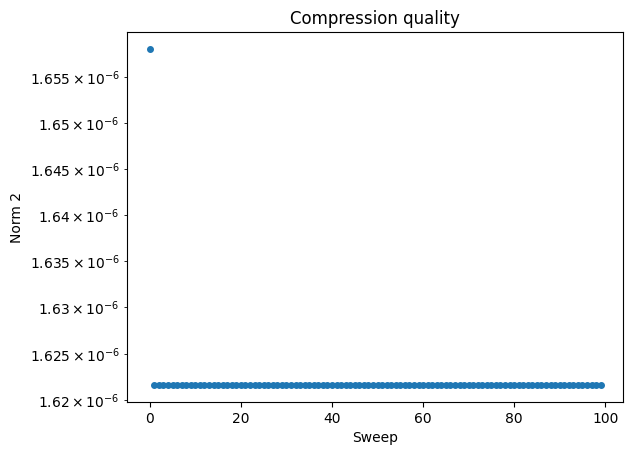

In [44]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(range(len(err_per_sweep)), err_per_sweep, s=16)
plt.yscale('log')
plt.xlabel('Sweep')
plt.ylabel('Norm 2')
plt.title('Compression quality')
plt.show()